<a href="https://colab.research.google.com/github/Taejin1221/Lab_Experiment/blob/main/Trajectory_Clustering/Trajectory_Clustering_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Set constants

In [1]:
import os, cv2, glob
import numpy as np

import matplotlib.pyplot as plt

In [4]:
WIDTH, HEIGHT = 8, 8

EXPERIMENT_DATA = {
    'name' : 'Trajectory_Clusetring',
    'number' : '23',
    'date' : '06-28-2021',
    'description' : 'Create Bitmap Encoder\n'
    }

ROOT_DIR = os.path.join('/content', 'drive', 'MyDrive', 'University', 'PiLab', 'Experiment')
os.chdir(ROOT_DIR)
print(os.getcwd())

DATA_DIR = os.path.join('/content', 'Bitmap')
RESULT_DIR = os.path.join(ROOT_DIR, 'Results')

/content/drive/MyDrive/University/PiLab/Experiment


In [5]:
os.chdir(RESULT_DIR)

NEW_RESULT_DIR = f"{EXPERIMENT_DATA['name']}_{EXPERIMENT_DATA['number']}_{EXPERIMENT_DATA['date']}_Data"
if (NEW_RESULT_DIR not in os.listdir()):
    os.mkdir(NEW_RESULT_DIR)
os.chdir(NEW_RESULT_DIR)

with open('Description.txt', 'w') as f:
    f.write(EXPERIMENT_DATA['description'])

In [9]:
os.chdir(DATA_DIR)
print(len(os.listdir()))

18670


# Load and Preprocess data

In [7]:
import zipfile

os.chdir('/content')
zip_file = zipfile.ZipFile("Bitmap.zip")

zip_file.extractall()

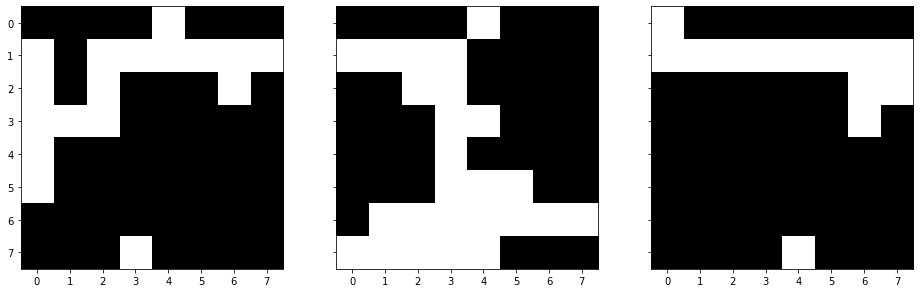

In [11]:
os.chdir(DATA_DIR)

bmp_data = [ ]
for name in sorted(glob.glob('*.png')):
    bmp_data.append(cv2.imread(name, cv2.IMREAD_GRAYSCALE))

fig, ax = plt.subplots(1, 3, sharex = True, sharey = True, figsize = (16, 48))
plt.gray()
ax[0].imshow(bmp_data[0])
ax[1].imshow(bmp_data[1])
ax[2].imshow(bmp_data[2])
plt.show()

In [12]:
X_train = np.array(bmp_data).astype('float32') / 255.
X_train = np.reshape(X_train, (-1, HEIGHT, WIDTH, 1))

In [13]:
print(X_train.shape)

(18670, 8, 8, 1)


# Build Models

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
act, pd = 'relu', 'same'

encoder_input = layers.Input((8, 8, 1))
x = layers.Conv2D(16, (3, 3), activation = act, padding = pd)(encoder_input)
x = layers.MaxPooling2D((2, 2), padding = pd)(x)
x = layers.Conv2D(8, (3, 3), activation = act, padding = pd)(x)
x = layers.MaxPooling2D((2, 2), padding = pd)(x)
x = layers.Conv2D(8, (3, 3), activation = act, padding = pd)(x)
x = layers.MaxPooling2D((2, 2), padding = pd)(x)

feature_map_shape = x.shape
flatten_size = feature_map_shape[1] * feature_map_shape[2] * feature_map_shape[3]

x = layers.Flatten()(x)
encoder_output = layers.Dense(flatten_size , activation = act)(x)

In [17]:
encoder = keras.Model(encoder_input, encoder_output, name = 'Encoder')
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 16)          160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 8)           1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 8)           0   

In [18]:
decoder_input = layers.Input((flatten_size))

x = layers.Dense(flatten_size, activation = act)(decoder_input)
x = layers.Reshape(feature_map_shape[1:])(x)

x = layers.Conv2DTranspose(8, (3, 3), activation = act, padding = pd)(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(8, (3, 3), activation = act, padding = pd)(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2DTranspose(16, (3, 3), activation = act, padding = pd)(x)
x = layers.UpSampling2D((2, 2))(x)

decoder_output = layers.Conv2DTranspose(1, (3, 3), activation = act, padding = pd)(x)

In [19]:
decoder = keras.Model(decoder_input, decoder_output, name = 'Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 8)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 1, 1, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 2, 2, 8)           584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 4, 4, 8)           0   

In [20]:
auto_encoder = keras.Model(encoder_input, decoder(encoder(encoder_input)), name = 'Auto_Encoder')
auto_encoder.summary()

Model: "Auto_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
Encoder (Functional)         (None, 8)                 1976      
_________________________________________________________________
Decoder (Functional)         (None, 8, 8, 1)           2553      
Total params: 4,529
Trainable params: 4,529
Non-trainable params: 0
_________________________________________________________________


In [21]:
auto_encoder.compile('adam', loss = 'mse')

# Train Model

In [22]:
EPOCH = 300
BATCH = 256

In [23]:
history = auto_encoder.fit(X_train, X_train, epochs = EPOCH, batch_size = BATCH)

Epoch 1/300
73/73 [==============================] - 32s 7ms/step - loss: 0.2120
Epoch 2/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1772
Epoch 3/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1518
Epoch 4/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1429
Epoch 5/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1324
Epoch 6/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1279
Epoch 7/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1257
Epoch 8/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1241
Epoch 9/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1227
Epoch 10/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1215
Epoch 11/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1205
Epoch 12/300
73/73 [==============================] - 0s 4ms/step - loss: 0.1195
Epoch 13/300
73/73 [================

In [24]:
os.chdir(os.path.join(RESULT_DIR, NEW_RESULT_DIR))

encoder.save('encoder.h5')
decoder.save('decoder.h5')
auto_encoder.save('auto_encoder.h5')

# Test Model

In [25]:
low_dimension_data = encoder(X_train)

In [26]:
low_dimension_data[0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([2.2357178, 5.2542934, 4.2102385, 5.590271 , 2.7670023, 0.       ,
       1.3716769, 3.4490964], dtype=float32)>

In [27]:
from scipy.spatial import distance
print(distance.cosine(low_dimension_data[0], low_dimension_data[1]))
print(distance.cosine(low_dimension_data[0], low_dimension_data[2]))
print(distance.cosine(low_dimension_data[1], low_dimension_data[2]))
print(distance.cosine(low_dimension_data[2], low_dimension_data[1]))

0.06379938125610352
0.05544102191925049
0.06279927492141724
0.06279927492141724
